<a href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/Double_Well_2D/Models/%5BFINAL%5Dunderpinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
# Install FEniCS and mshr
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [71]:
# Imports & FP64
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from fenics import *
import mshr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

# Solving for the MET of a given SDE in an ellipse with "Boundary Adapted PINNs": comparison with FEM solution

## 1) Setup

For $a=2$ and $b=1.5$, let $
\Omega := \{ (x,y)\in\mathbb{R}^2 : (x/a)^2 + (y/b)^2 < 1 \}$ be the ellipse centered at the origin with semi-axes $a$ (along $x$) and $b$ (along $y$). We consider a process driven by the double-well potential

$$
\Phi(x,y):= A\Bigl( 1-\exp\Bigl(-\frac{(x-1)^2+(y-0.5)^2}{\nu^2}\Bigr)\Bigr)
\Bigl( 1-\exp\Bigl(-\frac{(x+1)^2+(y+0.5)^2}{\nu^2}\Bigr)\Bigr),
$$  
with parameters $A>0$ (which controls the barrier height) and $\nu>0$ (which controls the width of the wells). Its associated drift is given by the negative gradient,
$$
b(x,y)= -\nabla\Phi(x,y)= \begin{pmatrix} b_1(x,y) \\ b_2(x,y) \end{pmatrix}.
$$

The stochastic differential equation solved by our process takes the form
$$
\begin{cases}
dX_t = b(X_t)\,dt + \sigma(X_t)\,dW_t,\\
X_0 = x\in\Omega,
\end{cases}
$$  
where the diffusion matrix is chosen as  
$$
\sigma(x,y)= \begin{pmatrix}
\sqrt{2\epsilon} & 0 \\
0 & \sqrt{\epsilon}
\end{pmatrix}
$$  
for some $\epsilon>0$, and $W_t$ is a two-dimensional standard Brownian motion.

For all $x\in\Omega$, we define the exit time
$$
T(x):=\inf\{t\ge 0: X_t\in\partial\Omega\},
$$  
and denote by
$$
\tau(x):=\mathbb{E}[T(x)]
$$  
its first moment (the mean exit time).

In this setting, one can show that $\tau$ is the (unique) solution of the boundary value problem
$$
\begin{cases}
-\mathcal{L} u(x) = 1 \quad \text{for all } x\in\Omega,\\[1mm]
u(x)= 0 \quad \text{for all } x\in\partial\Omega,
\end{cases}
$$  
where the infinitesimal generator $\mathcal{L}$ is given by
$$
\mathcal{L} u(x) = \epsilon\, u_{xx}(x) + \frac\epsilon2\, u_{yy}(x) + b_1(x,y)\, u_x(x) + b_2(x,y)\, u_y(x).
$$

**Derivation of the Weak Formulation:**

Multiplying the strong form of the PDE
$$
\epsilon\, u_{xx} + \frac\epsilon2\, u_{yy} + b_1\, u_x + b_2\, u_y = -1 \quad \text{in } \Omega,
$$  
by a test function $v\in H^1_0(\Omega)$ and integrating over $\Omega$, we obtain
$$
\int_\Omega \Bigl[ \epsilon\, u_{xx} +\frac\epsilon2\, u_{yy} + b_1\, u_x + b_2\, u_y \Bigr] v\,dx\,dy = -\int_\Omega v\,dx\,dy.
$$  
Integration by parts on the second derivative terms (with $v=0$ on $\partial\Omega$) yields
$$
\int_\Omega \Bigl(\epsilon\, u_x\, v_x + \frac\epsilon2\, u_y\, v_y \Bigr) dx\,dy - \int_\Omega \Bigl( b_1\, u_x + b_2\, u_y \Bigr) v\,dx\,dy = \int_\Omega v\,dx\,dy.
$$  
This is the weak formulation that we discretize using a Galerkin finite element method.

## Approximating the true solution with FEM

In [72]:
# Parameters controlling the double-well potential and diffusion.
#numpy version
A_np = 5.0      # Barrier height for the double-well potential
nu_np = 1e-1    # Width parameter of the wells in the potential
eps_np = 12e-1   # Diffusion parameter
#fenics version
A = Constant(A_np)
nu = Constant(nu_np)
epsilon = Constant(eps_np)

# Create the elliptical domain Omega
a = 2.0
b = 1.5
domain = mshr.Ellipse(Point(0.0, 0.0), a, b)
mesh = mshr.generate_mesh(domain, 64)

# FE function space and boundary conditions
V = FunctionSpace(mesh, "CG", 1)

# Homogeneous Dirichlet BC (u = 0 on the boundary)
u_D = Constant(0.0)
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary)

# Define the double-well potential and drift field
# using the spatial coordinates (x,y) from the mesh
x_coord = SpatialCoordinate(mesh)

# Double-well potential defined by:
#   Φ(x,y) = A [1 - exp(-((x-1)²+(y-0.5)²)/ν²)] [1 - exp(-((x+1)²+(y+0.5)²)/ν²)]
Phi = A * (1 - exp(-(((x_coord[0]-1)**2 + (x_coord[1]-0.5)**2) / (nu**2)))) \
        * (1 - exp(-(((x_coord[0]+1)**2 + (x_coord[1]+0.5)**2) / (nu**2))))

# The drift b(x,y) is the negative gradient of the potential.
db = -grad(Phi)
b1 = db[0]
b2 = db[1]

# Define the variational problem
u = TrialFunction(V)
v = TestFunction(V)

# The weak formulation reads:
# (ε u_x v_x + (ε/2) u_y v_y) dx - (b₁ u_x + b₂ u_y) v dx = ∫_Ω v dx

a_form = (epsilon * u.dx(0) * v.dx(0) + (epsilon/2) * u.dx(1) * v.dx(1)
          - (b1 * u.dx(0) + b2 * u.dx(1)) * v) * dx
L_form = v * dx

# Solve the problem
u_sol = Function(V)
solve(a_form == L_form, u_sol, bc)

# ------------------------
# Now u_h is the finite element solution (function of x and y)
# Example: Evaluating the solution at a specific point (x0, y0):
# pt = (0.0, 0.0)  # Example point at the center of the domain
# value_at_pt = u_sol(pt)
# print("The solution u_sol at point {} is: {}".format(pt, value_at_pt))

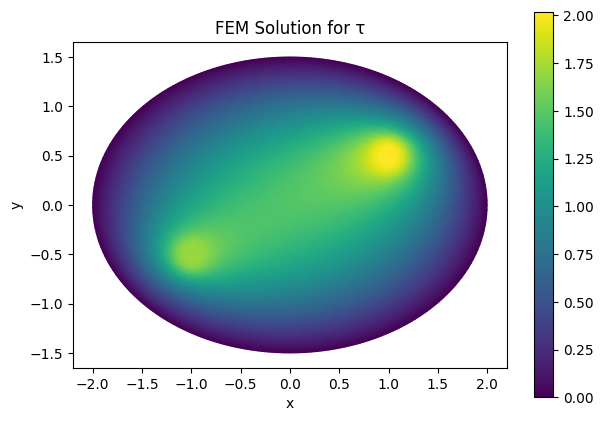

In [73]:
# plotting the solution
plt.figure(figsize=(7, 5))
p = plot(u_sol, title="FEM Solution for τ", mode="color")
plt.colorbar(p)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# plotting the mesh to see how the ellipse was discretized
# plt.figure(figsize=(7, 5))
# plot(mesh)
# plt.title("Mesh for the Elliptical Domain")
# plt.show()

## Neural Network architecture and loss function

Unlike the standard PINN, we will take an hypothesis space of Neural Networks which satisfy the boundary conditions explicitly. For this problem, we have homogenous zero Dirichlet boundary conditions, which we can enforce by multiplying our Neural Networks with an appropriate "smooth distance approximation" (see https://arxiv.org/abs/2104.08426). In accordance with the mentioned paper, we will take
$$\varphi : x\mapsto \frac{\omega(x)}{\sqrt{\omega(x)^2 + \|\nabla\omega(x)\|^2}},$$
where
$$\omega(x,y) = 1 - \left(\frac{x}{a}\right)^2 - \left(\frac{y}{b}\right)^2,\ \ \text{and }\ \ \|\nabla\omega(x,y)\|^2 = \left(\frac{2x}{a^2}\right)^2 + \left(\frac{2y}{b^2}\right)^2 $$
as our smooth distance approximation.  


With this modification, our objective to minimize becomes
$$\hat u := \arg\min_{u\in\mathcal{NN}_\varphi}\ \frac1n \sum_{i=1}^n (\mathcal L u(x_i^c) + 1)^2 $$
where $x_i^c$ are sampled i.i.d. with uniform distribution on $\Omega$, and the hypothesis space is given by
$$\mathcal{NN}_\varphi:=\left\{x\mapsto \varphi(x) \cdot T_L\circ \sigma \circ T_{L-1}\circ\cdots\circ \sigma\circ T_1 (x)\right\}, $$
for
$$T_\ell : \mathbb{R}^{\ell-1}\to\mathbb{R}^\ell $$
affine-linear maps of appropriate input-output dimensions, where
$$\sigma :x \mapsto \begin{cases}x^2 &\text{ if } x\ge 0\\ 0 &\text{ if } x\le 0\end{cases} \quad \text{OR }\ \ \sigma : x\mapsto \operatorname{tanh}(x),$$
is either the ReQU or hyperbolic tangent activation function, which is understood element-wise when applied to vectors.

In [74]:
# defining PINN w/ matching boundary condition
power = None #exponent k for relu^k, none for tanh
width = 30
depth = 3
gain = 2.0 #magnitude of weights at initialization

#define ReLU^k activation

class RePU(nn.Module):
    def __init__(self, power = power):
        super(RePU, self).__init__()
        self.power = power

    def forward(self, x):
        return torch.pow(torch.relu(x), self.power)

#define the smooth distance approximation
def smooth_distance(x, a=a, b=b):
    omega_x = 1 - (x[:,0]/a)**2 - (x[:,1]/b)**2
    grad_omega_x_sq = (2 * x[:,0]/a**2)**2 + (2 * x[:,1]/b**2)**2
    denominator = torch.sqrt(omega_x**2 + grad_omega_x_sq)
    return omega_x/denominator

#define hypothesis space
class BoundaryPINN(nn.Module):
    def __init__(self, power = power, width = width, depth = depth):
        super(BoundaryPINN,self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, width))
        if isinstance(power, int):
            self.layers.append(RePU(power))
            for _ in range(depth-1) :
                self.layers.append(nn.Linear(width, width))
                self.layers.append(RePU(power))
        else :
            self.layers.append(nn.Tanh())
            for _ in range(depth-1) :
                self.layers.append(nn.Linear(width, width))
                self.layers.append(nn.Tanh())
        self.layers.append(nn.Linear(width, 1))
        self.mlp = nn.Sequential(*self.layers)

        #for dynamic weighting
        self.log_sigma_pde = nn.Parameter(torch.tensor(-0.5,
                                                        dtype=torch.float64))
        self.log_sigma_data = nn.Parameter(torch.tensor(-0.5,
                                                        dtype=torch.float64))

    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        distance =  smooth_distance(x)**0.5
        return output * distance.unsqueeze(-1)

    def raw_forward(self, x):
        #returns the raw neural network output without multiplication by
        #distance to boundary
        return self.mlp(x)

#weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight, gain=gain)
        m.bias.data.fill_(gain)

In [75]:
# defining PDE Residual & Loss, enabling grad on x
def pde_residual(model, x, A, nu, epsilon, forcing=None):
    # ensure x is on the right device, float64, and requires grad
    x = x.clone().detach().to(device).requires_grad_(True)

    # unpack coordinates
    xs = x[:, 0]  # [N]
    ys = x[:, 1]  # [N]

    # squared distances to well centers
    d1_sq = (xs - 1.0)**2 + (ys - 0.5)**2
    d2_sq = (xs + 1.0)**2 + (ys + 0.5)**2

    # exponential terms
    exp1 = torch.exp(-d1_sq / (nu**2))  # e1
    exp2 = torch.exp(-d2_sq / (nu**2))  # e2

    # f1 = 1 - exp1, f2 = 1 - exp2
    f1 = 1.0 - exp1
    f2 = 1.0 - exp2

    # --- Compute ∇Φ analytically ---
    # ∂f1/∂x = (2/ν²)(x-1) exp1
    df1_dx = (2.0 / nu**2) * (xs - 1.0) * exp1
    df1_dy = (2.0 / nu**2) * (ys - 0.5) * exp1

    df2_dx = (2.0 / nu**2) * (xs + 1.0) * exp2
    df2_dy = (2.0 / nu**2) * (ys + 0.5) * exp2

    # ∇Φ = A * (∇f1 * f2 + f1 * ∇f2)
    dPhi_dx = A * (df1_dx * f2 + f1 * df2_dx)
    dPhi_dy = A * (df1_dy * f2 + f1 * df2_dy)

    # drift b = -∇Φ
    b1 = -dPhi_dx
    b2 = -dPhi_dy

    # forward through PINN
    tau = model(x)  # [N]

    # first derivatives
    grads = torch.autograd.grad(
        tau, x,
        grad_outputs=torch.ones_like(tau),
        create_graph=True,
    )[0]  # [N,2]
    tau_x, tau_y = grads[:, 0], grads[:, 1]

    # second derivatives
    tau_xx = torch.autograd.grad(
        tau_x, x,
        grad_outputs=torch.ones_like(tau_x),
        create_graph=True
    )[0][:, 0]

    tau_yy = torch.autograd.grad(
        tau_y, x,
        grad_outputs=torch.ones_like(tau_y),
        create_graph=True
    )[0][:, 1]

    # generator L[tau] = ε τ_xx + (ε/2) τ_yy + b1 τ_x + b2 τ_y
    phys = epsilon * tau_xx + 0.5 * epsilon * tau_yy + b1 * tau_x + b2 * tau_y

    # forcing term: default -1 (since -Lτ = 1 ⇒ Lτ = -1)
    if forcing is None:
        f_vals = -1.0
    elif isinstance(forcing, (int, float)):
        f_vals = float(forcing)
    elif callable(forcing):
        f_vals = forcing(x)
        if f_vals.dim() > 1:
            f_vals = f_vals.view(-1)
    else:
        raise ValueError(f"forcing must be None, float, or callable, got {type(forcing)}")

    if isinstance(f_vals, float) or isinstance(f_vals, int):
        f_vals = x.new_full((x.shape[0],), float(f_vals))

    # residual = L[tau](x) - f(x)
    r = phys - f_vals  # shape [N]
    return r


def loss_fn(res):
    return torch.mean(res.pow(2))

In [76]:
# Energy Hessian-vector product: Hv where H = d²E/du², E = mean(u²)
def energy_hvp(v_vec_full):
    # ------------------------------------------------------------------
    # 1. Keep only the *network* parameters (skip the two log-sigmas)
    # ------------------------------------------------------------------
    net_params = [p for p in model.parameters()
                  if p is not model.log_sigma_pde and p is not model.log_sigma_data]

    n_net = sum(p.numel() for p in net_params)

    # ------------------------------------------------------------------
    # 2. Project the incoming CG direction onto the network subspace
    # ------------------------------------------------------------------
    v_net = v_vec_full[:n_net]

    # ------------------------------------------------------------------
    # 3. Make *dummy* copies that are leaves with requires_grad=True
    # ------------------------------------------------------------------
    dummy = [p.detach().clone().requires_grad_(True) for p in net_params]
    backup = [p.data.clone() for p in net_params]      # to restore later
    for p, d in zip(net_params, dummy):
        p.data.copy_(d)

    try:
        # --------------------------------------------------------------
        # 4. Forward pass – energy = mean(u²)
        # --------------------------------------------------------------
        u = model(Xb_ft)
        energy = u.pow(2).mean()

        # --------------------------------------------------------------
        # 5. First-order gradient w.r.t. net_params (CHANGED: dummy -> net_params)
        # --------------------------------------------------------------
        g_list = torch.autograd.grad(
            energy, net_params,  # CHANGED
            create_graph=True,          # we need the graph for the HVP
            allow_unused=True
        )
        # replace missing grads with zeros (CHANGED: dummy -> net_params)
        g_list = [g if g is not None else torch.zeros_like(p) for g, p in zip(g_list, net_params)]  # CHANGED

        # --------------------------------------------------------------
        # 6. **Flatten inside the graph** – this keeps grad_fn alive
        # --------------------------------------------------------------
        grad_flat = torch.cat([g.flatten() for g in g_list])
        grad_flat = grad_flat * 1.0      # <- dummy op that forces a graph node

        # --------------------------------------------------------------
        # 7. Hessian-vector product (CHANGED: dummy -> net_params)
        # --------------------------------------------------------------
        hvp_list = torch.autograd.grad(
            grad_flat, net_params,  # CHANGED
            grad_outputs=v_net,
            allow_unused=True
        )
        hvp_list = [h if h is not None else torch.zeros_like(p) for h, p in zip(hvp_list, net_params)]  # CHANGED

        hvp_flat = torch.cat([h.flatten() for h in hvp_list])

        # --------------------------------------------------------------
        # 8. Pad back to the *full* parameter vector size
        # --------------------------------------------------------------
        hvp_full = torch.zeros_like(v_vec_full)
        hvp_full[:n_net] = hvp_flat
        return hvp_full

    finally:
        # --------------------------------------------------------------
        # 9. Restore the original model parameters (critical!)
        # --------------------------------------------------------------
        for p, b in zip(net_params, backup):
            p.data.copy_(b)

## Computing an approximate data penalty regularization

We sample a small subset $x_1, \ldots, x_{n_{d}} \in \Omega$ of points for which we compute approximate values $\tau^{MC}(x_1), \ldots, \tau^{MC}(x_{n_{d}}) $ by Monte Carlo. we will then use them to define a "data-fidelity" penalty term in the loss function:
$$\text{Penalty}(\hat\tau_{NN}) = \frac{\lambda_{d}}{n_{d}} \sum_{i=1}^{n_d} \left(\tau^{MC}(x_i) - \hat\tau_{NN}(x_i)\right)^2, $$
where $\lambda_{d}$ is a positive regularization parameter.

In [77]:
# generating some approximate true solutions in the domain

# sampling anchor points, uniform in the ellipse
@torch.no_grad()
def sample_ellipse(batch_size, a=2.0, b=1.5):
    """
    Sample uniformly in the ellipse: (x/a)^2 + (y/b)^2 <= 1.
    Uses rejection sampling in the bounding box [-a,a] x [-b,b].
    """
    collected = []  # List of [num_in, 2] tensors
    needed = batch_size
    while needed > 0:
        x = (2 * torch.rand(batch_size, device=device) - 1) * a  # [-a, a]
        y = (2 * torch.rand(batch_size, device=device) - 1) * b  # [-b, b]
        inside = (x/a)**2 + (y/b)**2 <= 1.0
        points_in = torch.stack([x[inside], y[inside]], dim=1)  # [num_in, 2]
        collected.append(points_in)
        needed -= points_in.shape[0]

    all_points = torch.cat(collected, dim=0)  # [total >= batch_size, 2]
    if all_points.shape[0] > batch_size:
        idx = torch.randperm(all_points.shape[0], device=device)[:batch_size]
        all_points = all_points[idx]
    return all_points


# 2) monte-carlo (euler-maruyama) approximation of tau at these points
@torch.no_grad()
def mc_exit_time(x0, A, nu, epsilon,
                 n_paths=128, dt=1e-3, max_steps=20000):
    """
    x0: [B,2] starting points
    Returns tau_hat: [B] = mean exit time from each x0.
    Any path still 'alive' after max_steps is counted as having exit time = max_steps*dt.
    """
    B = x0.shape[0]
    P = n_paths

    # Expand to per-path positions — CONTIGUOUS
    X = x0.unsqueeze(1).expand(B, P, 2).contiguous()  # [B,P,2]
    t = torch.zeros(B, P, device=device)
    alive = torch.ones(B, P, dtype=torch.bool, device=device)

    # Precompute diffusion
    dt_t = torch.as_tensor(dt, device=device, dtype=torch.float32)
    epsilon_t = torch.as_tensor(epsilon, device=device, dtype=torch.float32)
    sqrt_dt_x = torch.sqrt(2 * epsilon_t * dt_t)
    sqrt_dt_y = torch.sqrt(epsilon_t * dt_t)
    #sqrt_dt_x = (2 * epsilon * dt)**0.5
    #sqrt_dt_y = (epsilon * dt)**0.5

    print_interval = max(1, max_steps // 100)  # at most 100 updates

    # --- Main loop: work on FULL batch, mask updates ---
    for step in range(max_steps):
        if not alive.any():
            break

        # Work on full [B,P,2] tensor — fully vectorized
        xs = X[..., 0]  # [B,P]
        ys = X[..., 1]  # [B,P]

        # --- Double-well drift: fully vectorized ---
        d1_sq = (xs - 1.0)**2 + (ys - 0.5)**2
        d2_sq = (xs + 1.0)**2 + (ys + 0.5)**2
        exp1 = torch.exp(-d1_sq / nu**2)
        exp2 = torch.exp(-d2_sq / nu**2)
        f1 = 1.0 - exp1
        f2 = 1.0 - exp2

        df1_dx = (2.0 / nu**2) * (xs - 1.0) * exp1
        df1_dy = (2.0 / nu**2) * (ys - 0.5) * exp1
        df2_dx = (2.0 / nu**2) * (xs + 1.0) * exp2
        df2_dy = (2.0 / nu**2) * (ys + 0.5) * exp2

        dPhi_dx = A * (df1_dx * f2 + f1 * df2_dx)
        dPhi_dy = A * (df1_dy * f2 + f1 * df2_dy)

        drift_x = -dPhi_dx * dt
        drift_y = -dPhi_dy * dt

        # Noise: full batch
        noise_x = sqrt_dt_x * torch.randn_like(xs)
        noise_y = sqrt_dt_y * torch.randn_like(ys)

        # Update ONLY alive paths
        X[..., 0] += drift_x
        X[..., 1] += drift_y
        X[..., 0][~alive] -= drift_x[~alive]  # undo
        X[..., 1][~alive] -= drift_y[~alive]  # undo
        X[..., 0] += noise_x
        X[..., 1] += noise_y
        X[..., 0][~alive] -= noise_x[~alive]
        X[..., 1][~alive] -= noise_y[~alive]

        t += dt
        t[~alive] -= dt  # don't advance time for dead paths

        # Check exit on full batch
        exited = (X[..., 0]/a)**2 + (X[..., 1]/b)**2 >= 1.0
        just_exited = exited & alive
        alive[just_exited] = False

        if step % print_interval == 0 or step == max_steps - 1:
            frac_alive = alive.float().mean().item()
            current_t = step * dt
            print(f"Step {step} | t = {current_t:.2f} | alive: {frac_alive*100:.3f}%", flush=True)


    tau_hat = t.mean(dim=1)  # [B]
    return tau_hat

In [78]:
# defining Uniform + Boundary Sampling functions in the ellipse
def sample_uniform_ellipse(N, a=2.0, b=1.5):
    """
    Uniform sampling in ellipse using rejection (same as sample_ellipse but fixed N)
    """
    return sample_ellipse(N, a=a, b=b)


def sample_boundary(N, a=2.0, b=1.5):
    """
    Uniform sampling on the boundary of the ellipse: (x/a)^2 + (y/b)^2 = 1
    Parameterized by angle θ ∈ [0, 2π)
    """
    theta = 2 * math.pi * torch.rand(N, device=device)
    x = a * torch.cos(theta)
    y = b * torch.sin(theta)
    return torch.stack([x, y], dim=1)  # [N,2]

## Training Loop

### Training Parameters

In [79]:
# Training parameters
pool_size        = 8192
n_batches        = 16
batch_size       = pool_size // n_batches
n_epochs         = 5_000
learning_rate    = 5e-4

# model instantiation
model = BoundaryPINN(power, width, depth).to(device)
model.apply(init_weights)

opt   = torch.optim.Adam(list(model.parameters()), lr=learning_rate)

# scheduler: every `epochs_between_decays` epochs, multiply lr by gamma
num_decays = 100
epochs_between_decay = n_epochs // num_decays
final_factor = 1e-3
gamma = np.exp(np.log(final_factor) / num_decays)

scheduler = torch.optim.lr_scheduler.StepLR(
    opt,
    step_size=epochs_between_decay,  # decay every N epochs
    gamma=gamma                      # LR *= gamma at each decay
)

### Generating the "data-fidelity" samples

In [80]:
# sample x_data
x_data = sample_uniform_ellipse(batch_size//2)

max_time = 15
dt = 2e-4

# precompute tau_data once
tau_data = mc_exit_time(
    x0       = x_data,
    A        = A_np,
    nu       = nu_np,
    epsilon  = eps_np,
    n_paths  = 256,
    dt       = dt,
    max_steps= int(max_time / dt)
)

Step 0 | t = 0.00 | alive: 99.025%
Step 750 | t = 0.15 | alive: 63.463%
Step 1500 | t = 0.30 | alive: 50.539%
Step 2250 | t = 0.45 | alive: 41.631%
Step 3000 | t = 0.60 | alive: 34.822%
Step 3750 | t = 0.75 | alive: 29.462%
Step 4500 | t = 0.90 | alive: 25.096%
Step 5250 | t = 1.05 | alive: 21.289%
Step 6000 | t = 1.20 | alive: 18.147%
Step 6750 | t = 1.35 | alive: 15.671%
Step 7500 | t = 1.50 | alive: 13.330%
Step 8250 | t = 1.65 | alive: 11.459%
Step 9000 | t = 1.80 | alive: 9.921%
Step 9750 | t = 1.95 | alive: 8.562%
Step 10500 | t = 2.10 | alive: 7.393%
Step 11250 | t = 2.25 | alive: 6.387%
Step 12000 | t = 2.40 | alive: 5.475%
Step 12750 | t = 2.55 | alive: 4.723%
Step 13500 | t = 2.70 | alive: 4.086%
Step 14250 | t = 2.85 | alive: 3.584%
Step 15000 | t = 3.00 | alive: 3.087%
Step 15750 | t = 3.15 | alive: 2.675%
Step 16500 | t = 3.30 | alive: 2.321%
Step 17250 | t = 3.45 | alive: 1.961%
Step 18000 | t = 3.60 | alive: 1.691%
Step 18750 | t = 3.75 | alive: 1.472%
Step 19500 | t = 3

### Starting the training with Adam

In [81]:
# Training Loop w/ Loss Logging

# prep for best‐model tracking
best_loss       = float("inf")
adam_model_path = "best_adam.pth"
best_epoch = 0
eval_Xb = sample_uniform_ellipse(pool_size) #to evaluate the model

total_history = []
pde_history   = []
data_history  = []

model.train()
for ep in range(1, n_epochs+1):

    opt.zero_grad()

    Xb = sample_uniform_ellipse(batch_size)# → [batch_size,2]

    # PDE residual + loss
    r        = pde_residual(model, Xb, A_np, nu_np, eps_np, forcing = None)
    loss_pde = loss_fn(r)

    # data‐loss (fixed x_data, tau_data)
    tau_pred  = model(x_data).squeeze(-1)
    loss_data = (tau_pred - tau_data).pow(2).mean()

    # Sobolev penalty on the raw NN output
    # h2_reg = empirical_h2_norm(model, Xb)

    # total + backward + step
    loss_total = (torch.exp(-2 * model.log_sigma_pde) * loss_pde
               + torch.exp(-2 * model.log_sigma_data) * loss_data
               #+ lambda_sobolev * h2_reg
               + model.log_sigma_pde
               + model.log_sigma_data
    )

    # 6) backward + step
    loss_total.backward()
    opt.step()
    scheduler.step()

    #eval
    r_eval        = pde_residual(model, eval_Xb, A_np, nu_np, eps_np, forcing = None)  #evaluate the model on the true PDE
    loss_eval     = loss_fn(r_eval).item() #+ lambda_data * loss_data.item()

    if loss_eval < best_loss or ep - best_epoch >= epochs_between_decay * 10 :
        best_loss = loss_eval
        torch.save(model.state_dict(), adam_model_path)
        best_epoch = ep

    # 7) logging & histories
    #total_history.append(loss_total.item())
    total_history.append(loss_total.item() \
                            - (model.log_sigma_pde.detach()\
                            + model.log_sigma_data.detach()).item())
    pde_history.append(loss_pde.item())
    data_history.append(loss_data.item())

    if ep % 100 == 0:
        print(
            f"[ep {ep:4d}/{n_epochs}] "
            f"loss_pde={loss_pde:.2e}  "
            f"loss_data={loss_data:.2e}  "
            #f"h2_reg={h2_reg:.2e}"
        )
    if ep % 500 == 0:
        lr = scheduler.get_last_lr()[0]
        print(f"  → epoch {ep:4d},  lr={lr:.2e}")

[ep  100/5000] loss_pde=2.81e+04  loss_data=7.08e-01  
[ep  200/5000] loss_pde=1.84e+05  loss_data=2.95e-01  
[ep  300/5000] loss_pde=2.73e+07  loss_data=1.44e-01  
[ep  400/5000] loss_pde=5.69e+05  loss_data=1.32e-01  
[ep  500/5000] loss_pde=4.77e+04  loss_data=1.11e-01  
  → epoch  500,  lr=2.51e-04
[ep  600/5000] loss_pde=6.36e+03  loss_data=2.88e-02  
[ep  700/5000] loss_pde=2.53e+03  loss_data=1.07e-01  
[ep  800/5000] loss_pde=7.36e+03  loss_data=1.08e-01  
[ep  900/5000] loss_pde=6.08e+05  loss_data=1.08e-01  
[ep 1000/5000] loss_pde=2.09e+05  loss_data=1.11e-01  
  → epoch 1000,  lr=1.26e-04
[ep 1100/5000] loss_pde=3.77e+03  loss_data=1.13e-01  
[ep 1200/5000] loss_pde=1.23e+04  loss_data=1.13e-01  
[ep 1300/5000] loss_pde=2.02e+03  loss_data=2.12e-01  
[ep 1400/5000] loss_pde=1.12e+03  loss_data=2.16e-01  
[ep 1500/5000] loss_pde=8.62e+03  loss_data=2.16e-01  
  → epoch 1500,  lr=6.29e-05
[ep 1600/5000] loss_pde=1.88e+04  loss_data=2.16e-01  
[ep 1700/5000] loss_pde=5.34e+05 

### L-BFGS Fine Tuning

In [82]:
#LBFGS fine-tuning

# Reload best Adam snapshot
print(f"\nLoading best Adam model (loss={best_loss:.3e}, epoch={best_epoch}) …")
model.load_state_dict(torch.load(adam_model_path))
model.to(device)


# define L-BFGS parameters
lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter= 3*n_epochs,
    history_size=500,
    tolerance_grad = 0,
    tolerance_change = 0,
    line_search_fn="strong_wolfe"
)

max_eval = lbfgs.defaults.get('max_eval')

# freeze one big PDE batch for the closure
Xb_ft = sample_uniform_ellipse(pool_size)

lbfgs_total = []
lbfgs_pde   = []
lbfgs_data  = []

#closure function
def closure():
    closure.calls += 1
    lbfgs.zero_grad()
    # PDE term
    r_ft    = pde_residual(model, Xb_ft, A_np, nu_np, eps_np, forcing = None)
    pde_l   = loss_fn(r_ft)

    # data term
    tau_p   = model(x_data).squeeze(-1)
    data_l  = (tau_p - tau_data).pow(2).mean()

    #h2_reg =  empirical_h2_norm(model, Xb_ft)

    #total_l = pde_l + lambda_data * data_l
    total_l = (torch.exp(-2 * model.log_sigma_pde) * pde_l
            + torch.exp(-2 * model.log_sigma_data) * data_l
            #+ lambda_sobolev * h2_reg
            + model.log_sigma_pde
            + model.log_sigma_data
    )
    # record
    #lbfgs_total.append(total_l.item())
    lbfgs_total.append(total_l.item() - \
            (model.log_sigma_pde.detach() + model.log_sigma_data).item())
    lbfgs_pde.append(pde_l.item())
    lbfgs_data.append(data_l.item())

    total_l.backward()

    PRINT_EVERY = 100
    if closure.calls % PRINT_EVERY == 0:
        print(
            f"eval {closure.calls}/{max_eval} | "
            f"loss pde {pde_l:.2e} | "
            f"loss data {data_l:.2e}"
        )
    return total_l

closure.calls = 0


Loading best Adam model (loss=8.416e+05, epoch=5000) …


In [83]:
# report losses before/after lbfgs
# make sure model is in eval mode so e.g. Dropout/BatchNorm won’t move
model.eval()

# PDE loss
r_before = pde_residual(model, Xb_ft, A_np, nu_np, eps_np, forcing = None)
before_pde = loss_fn(r_before).item()

# empirical Sobolev norm
#before_h2 = empirical_h2_norm(model, Xb_ft).item()

# data loss (doesn't need grads)
with torch.no_grad():
    tau_p       = model(x_data).squeeze(-1)
    before_data = (tau_p - tau_data).pow(2).mean()

print(f"Before L-BFGS → PDE {before_pde:.3e}, DATA {before_data:.3e}")#, SOBOLEV {before_h2:.2e})

# running L-BFGS
print("→ Running L-BFGS...")
loss_after = lbfgs.step(closure)
print(f"L-BFGS did {closure.calls} closure calls, final total loss = {loss_after:.2e}")

Before L-BFGS → PDE 6.587e+06, DATA 3.423e-01
→ Running L-BFGS...
eval 100/18750 | loss pde 1.66e+00 | loss data 5.70e-01
eval 200/18750 | loss pde 1.05e+00 | loss data 5.66e-01
eval 300/18750 | loss pde 1.14e+00 | loss data 5.56e-01
eval 400/18750 | loss pde 1.22e+00 | loss data 5.52e-01
eval 500/18750 | loss pde 1.32e+00 | loss data 5.53e-01
eval 600/18750 | loss pde 1.14e+00 | loss data 5.57e-01
eval 700/18750 | loss pde 1.06e+00 | loss data 5.60e-01
eval 800/18750 | loss pde 1.04e+00 | loss data 5.61e-01
eval 900/18750 | loss pde 1.03e+00 | loss data 5.58e-01
eval 1000/18750 | loss pde 9.99e-01 | loss data 5.62e-01
eval 1100/18750 | loss pde 9.97e-01 | loss data 5.63e-01
eval 1200/18750 | loss pde 9.97e-01 | loss data 5.63e-01
eval 1300/18750 | loss pde 9.96e-01 | loss data 5.63e-01
eval 1400/18750 | loss pde 9.96e-01 | loss data 5.63e-01
eval 1500/18750 | loss pde 9.98e-01 | loss data 5.60e-01
eval 1600/18750 | loss pde 9.97e-01 | loss data 5.59e-01
eval 1700/18750 | loss pde 9.98

In [84]:
# after L-BFGS, same pattern:
model.eval()
r_after = pde_residual(model, Xb_ft, A_np, nu_np, eps_np, forcing = None)
after_pde = loss_fn(r_after).item()
#after_h2 = empirical_h2_norm(model, Xb_ft).item()
with torch.no_grad():
    tau_p       = model(x_data).squeeze(-1)
    after_data = (tau_p - tau_data).pow(2).mean()
print(f" After L-BFGS → PDE {after_pde:.3e}, DATA {after_data:.3e}")

# saving the L-BFGS fine-tuned model
lbfgs_model_path = 'lbfgs_finetuned.pth'
torch.save(model.state_dict(), lbfgs_model_path)

 After L-BFGS → PDE 1.118e+00, DATA 4.298e-01


### ENGD Fine Tuning

In [85]:
# Loading the post LBFGS model
print(f"\nLoading post L-BFGS model (losses: TOTAL={loss_after:.2e}, PDE={after_pde:.2e}, DATA {after_data:.2e})")
model.load_state_dict(torch.load(lbfgs_model_path))
model.to(device)

# Reuse same PDE batch as L-BFGS
Xb_ft = sample_uniform_ellipse(pool_size)
Xb_ft.requires_grad_(True)

# Logging
engd_total = []
engd_pde   = []
engd_data  = []

# Parameter shapes for HVP
param_shapes = [p.shape for p in model.parameters() if p.requires_grad]


Loading post L-BFGS model (losses: TOTAL=1.69e+07, PDE=1.12e+00, DATA 4.30e-01)


In [86]:
#  ENGD loop hyperparameters
engd_steps = 10
damping = 5e-1
engd_lr = 5e-7
cg_maxiter = 10
cg_tol = 1e-9

for step in range(1, engd_steps + 1):
    model.zero_grad()

    # === PDE loss ===
    r = pde_residual(model, Xb_ft, A_np, nu_np, eps_np, forcing=None)
    pde_l = loss_fn(r)

    # === Data loss ===
    tau_p = model(x_data).squeeze(-1)
    data_l = (tau_p - tau_data).pow(2).mean()

    # === Total loss (EXACT same as L-BFGS) ===
    total_l = (torch.exp(-2 * model.log_sigma_pde) * pde_l +
               torch.exp(-2 * model.log_sigma_data) * data_l +
               model.log_sigma_pde + model.log_sigma_data)

    # === Logging (exclude log terms from total) ===
    engd_total.append(total_l.item() - (model.log_sigma_pde.item() + model.log_sigma_data.item()))
    engd_pde.append(pde_l.item())
    engd_data.append(data_l.item())

    # === Backward ===
    total_l.backward()
    g_flat = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])
    #g_norm = torch.norm(g_flat).item()
    #print(f"ENGD step {step}: pre-CG ||g|| = {g_norm:.2e}, total_loss = {total_l.item():.2e}")


    # === CG solve: (H + λI) s = -g ===
    s = torch.zeros_like(g_flat)
    r_cg = -g_flat.clone()
    p_cg = r_cg.clone()
    rs_old = torch.dot(r_cg, r_cg)

    for cg_iter in range(cg_maxiter):
        Ap = energy_hvp(p_cg) + damping * p_cg
        alpha = rs_old / (torch.dot(p_cg, Ap) + 1e-12)
        s += alpha * p_cg
        r_cg -= alpha * Ap
        rs_new = torch.dot(r_cg, r_cg)
        if torch.sqrt(rs_new) < cg_tol * torch.sqrt(rs_old):
            break
        p_cg = r_cg + (rs_new / rs_old) * p_cg
        rs_old = rs_new

    #s_norm = torch.norm(s).item()
    #print(f"ENGD step {step}: post-CG ||s|| = {s_norm:.2e}, rs_new = {rs_new:.2e} (CG iters: {_ + 1})")

    # === Update parameters ===
    offset = 0
    for p in model.parameters():
        if p.grad is None: continue
        numel = p.numel()
        p.data.add_(engd_lr * s[offset:offset + numel].view_as(p))
        offset += numel

    # === Print ===
    if step % 25 == 0 or step == engd_steps:
        s_norm = torch.norm(s).item()
        g_norm = torch.norm(g_flat).item()
        print(f"ENGD [{step:3d}/{engd_steps}] | "
              f"Total {engd_total[-1]:.2e} | PDE {pde_l:.2e} | Data {data_l:.2e}"
              f"\npre-CG ||g|| = {g_norm:.2e}, post-CG ||s|| = {s_norm:.2e}, rs_new = {rs_new:.2e} (CG iters: {cg_iter + 1})"
              )

ENGD [ 10/10] | Total 0.00e+00 | PDE 4.06e+23 | Data 2.24e+07
pre-CG ||g|| = 1.41e+00, post-CG ||s|| = 1.68e-07, rs_new = 6.46e+02 (CG iters: 10)


In [87]:
# after ENGD, same pattern:
model.eval()
r_after_ngd = pde_residual(model, Xb_ft, A_np, nu_np, eps_np, forcing = None)
after_ngd_pde = loss_fn(r_after_ngd).item()
with torch.no_grad():
    tau_p       = model(x_data).squeeze(-1)
    after_ngd_data = (tau_p - tau_data).pow(2).mean()
print(f" After ENGD → PDE {after_ngd_pde:.3e}, DATA {after_ngd_data:.3e}")

# saving the L-BFGS fine-tuned model
engd_model_path = 'engd_finetuned.pth'
torch.save(model.state_dict(), engd_model_path)

 After ENGD → PDE 4.059e+23, DATA 2.241e+07


## Plotting the Results

### Training Curves

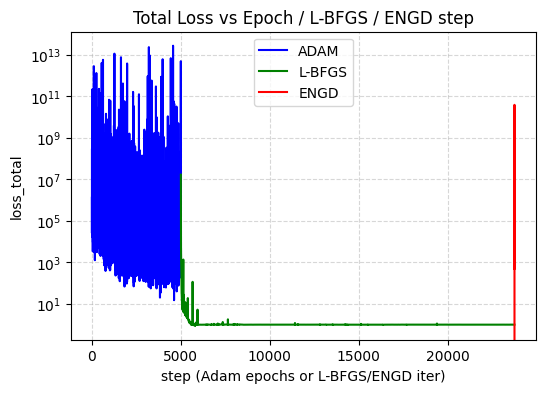

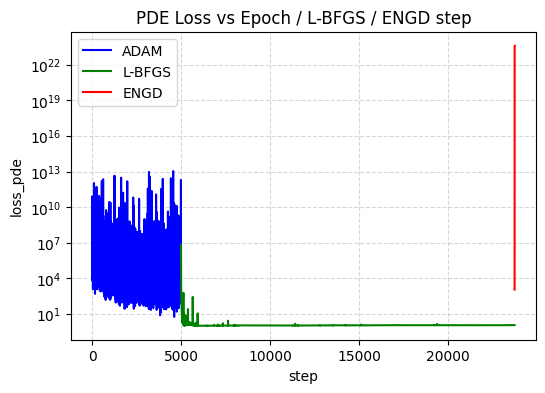

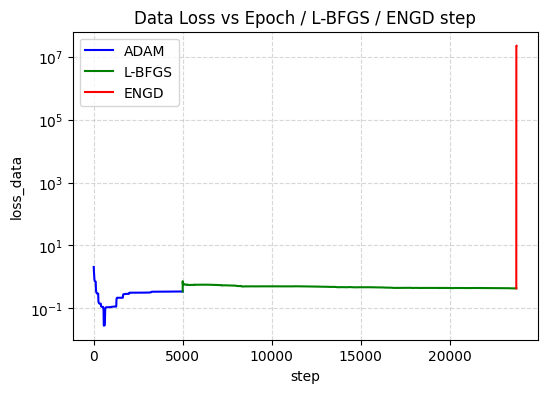

In [88]:
# --------------------------------------------------------------
#  Plotting three separate loss evolutions
# --------------------------------------------------------------
adam_end   = n_epochs
lbfgs_end  = adam_end + len(lbfgs_total)
engd_end   = lbfgs_end + len(engd_total)

total_history = total_history + lbfgs_total + engd_total
pde_history   = pde_history + lbfgs_pde + engd_pde
data_history   = data_history + lbfgs_data + engd_data

# a) Total Loss
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(adam_end), total_history[:adam_end], color='blue', label="ADAM")
plt.semilogy(np.arange(adam_end, lbfgs_end), total_history[adam_end:lbfgs_end], color='green', label="L-BFGS")
plt.semilogy(np.arange(lbfgs_end, engd_end), total_history[lbfgs_end:engd_end], color='red', label="ENGD")
plt.title("Total Loss vs Epoch / L-BFGS / ENGD step")
plt.xlabel("step (Adam epochs or L-BFGS/ENGD iter)")
plt.ylabel("loss_total")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# b) PDE Loss
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(adam_end), pde_history[:adam_end], color='blue', label="ADAM")
plt.semilogy(np.arange(adam_end, lbfgs_end), pde_history[adam_end:lbfgs_end], color='green', label="L-BFGS")
plt.semilogy(np.arange(lbfgs_end, engd_end), pde_history[lbfgs_end:engd_end], color='red', label="ENGD")
plt.title("PDE Loss vs Epoch / L-BFGS / ENGD step")
plt.xlabel("step")
plt.ylabel("loss_pde")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# c) Data Loss
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(adam_end), data_history[:adam_end], color='blue', label="ADAM")
plt.semilogy(np.arange(adam_end, lbfgs_end), data_history[adam_end:lbfgs_end], color='green', label="L-BFGS")
plt.semilogy(np.arange(lbfgs_end, engd_end), data_history[lbfgs_end:engd_end], color='red', label="ENGD")
plt.title("Data Loss vs Epoch / L-BFGS / ENGD step")
plt.xlabel("step")
plt.ylabel("loss_data")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

### Learned Solution vs FEM Solution

In [89]:
# Choose model to evaluate

choice = 2 #input("Enter 1, 2 or 3: ").strip()

model = BoundaryPINN(power, width, depth)
if choice == 1:
    model.load_state_dict(torch.load(adam_model_path))
    print("Loaded Adam-only model")
elif choice == 2:
    model.load_state_dict(torch.load(lbfgs_model_path))
    print("Loaded L-BFGS fine-tuned model")
elif choice == 3:
    model.load_state_dict(torch.load(engd_model_path))
    print("Loaded L-BFGS + ENGD fine-tuned model")
else:
    raise ValueError("Invalid choice")

model.to(device)
model.eval()

Loaded L-BFGS fine-tuned model


BoundaryPINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=1, bias=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=1, bias=True)
  )
)

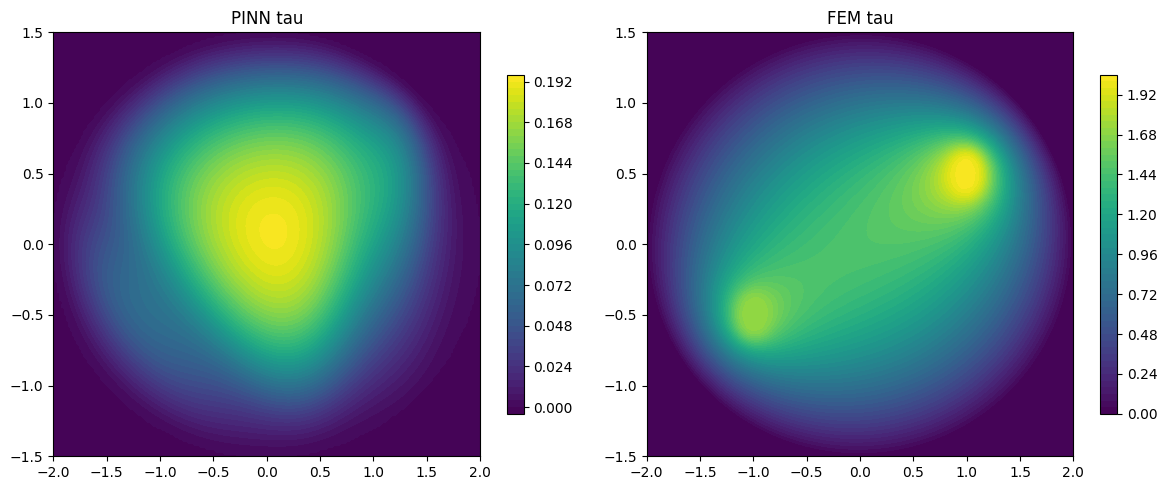

In [90]:
#Visualize PINN vs True tau

n_pts = 200
xx, yy = np.meshgrid(
    np.linspace(-a,a,n_pts),
    np.linspace(-b,b,n_pts)
)
mask = (xx/a)**2 + (yy/b)**2 <= 1.0
pts = np.vstack([xx[mask], yy[mask]]).T

with torch.no_grad():
    inp = torch.from_numpy(pts).to(device)
    pred = model(inp).cpu().numpy().squeeze(-1)

Zp = np.zeros_like(xx); Zt = np.zeros_like(xx)
Zp[mask] = pred
Zt[mask] = np.array([u_sol(x, y) for x, y in pts])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
cf1 = ax1.contourf(xx, yy, Zp, levels=50, cmap='viridis')
ax1.set_title('PINN tau')
fig.colorbar(cf1, ax=ax1, shrink=0.8)

cf2 = ax2.contourf(xx, yy, Zt, levels=50, cmap='viridis')
ax2.set_title('FEM tau')
fig.colorbar(cf2, ax=ax2, shrink=0.8)
plt.tight_layout()
plt.show()

### Relative and Pointwise error

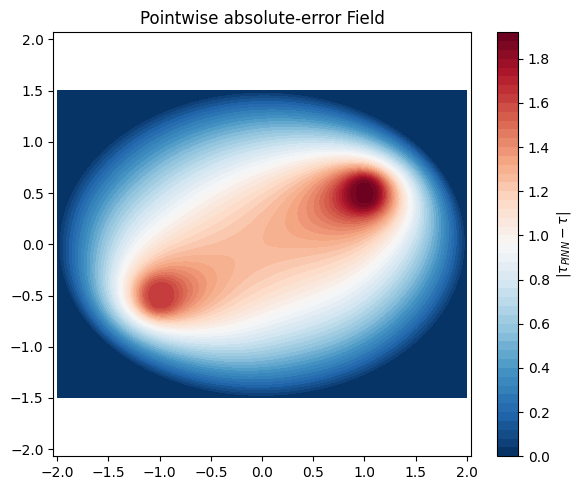

In [91]:
# pointwise L1 error
Z_err = np.abs(Zp - Zt)
plt.figure(figsize=(6,5))
cf = plt.contourf(xx, yy, Z_err, levels=50, cmap='RdBu_r')
plt.colorbar(cf, label=r'$|\tau_{PINN}-\tau|$')
plt.title('Pointwise absolute‐error Field')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [92]:
# average relative L2 error
#    ‖tau_pinn − tau_true‖₂ / ‖tau_true‖₂   (empirical L²(Ω) norm)
pred_vals = pred
true_vals = np.array([u_sol(x, y) for x, y in pts])

# Empirical L² norm of true solution: √( (1/n) Σ τ_true² )
tau_l2_norm = np.sqrt(np.mean(true_vals**2))
glob_rel_L2 = np.sqrt(np.mean((pred_vals - true_vals)**2)) / tau_l2_norm
print(f"Global relative L2 error: {glob_rel_L2:.3e} (true solution L2 norm: {tau_l2_norm:.3e})")

# average relative L1 error
#     ‖tau_pinn − tau_true‖₁ / ‖tau_true‖₁   (empirical L¹(Ω) norm)
tau_l1_norm = np.mean(np.abs(true_vals))
glob_rel_L1 = np.mean(np.abs(pred_vals - true_vals)) / tau_l1_norm
print(f"Global relative L1 error: {glob_rel_L1:.3e} (true solution L1 norm: {tau_l1_norm:.3e})")

# Sobolev H1 and H2 errors (finite difference on full grid)

# Compute grid spacings in x and y for the ellipse:
dx = (2 * a) / (n_pts - 1)
dy = (2 * b) / (n_pts - 1)

# Error field on the full grid
Z_err = Zp - Zt

# First derivatives of the error field using finite differences
derr_dy, derr_dx = np.gradient(Z_err, dy, dx)
grad_err_sq = derr_dx[mask]**2 + derr_dy[mask]**2

# Second derivatives of the error field
d2err_dx2 = np.gradient(derr_dx, dx, axis=1)
d2err_dy2 = np.gradient(derr_dy, dy, axis=0)
d2err_dxdy = np.gradient(derr_dy, dx, axis=1)
hess_err_sq = d2err_dx2[mask]**2 + d2err_dy2[mask]**2 + 2 * d2err_dxdy[mask]**2

# Compute derivatives for the true solution field (Zt) on the full grid
dt_dy, dt_dx = np.gradient(Zt, dy, dx)
grad_t_sq = dt_dx[mask]**2 + dt_dy[mask]**2

d2t_dx2 = np.gradient(dt_dx, dx, axis=1)
d2t_dy2 = np.gradient(dt_dy, dy, axis=0)
d2t_dxdy = np.gradient(dt_dy, dx, axis=1)
hess_t_sq = d2t_dx2[mask]**2 + d2t_dy2[mask]**2 + 2 * d2t_dxdy[mask]**2

# Compute the H¹ and H² norms of the true solution
tau_h1_norm = np.sqrt(np.mean(Zt[mask]**2 + grad_t_sq))
tau_h2_norm = np.sqrt(np.mean(Zt[mask]**2 + grad_t_sq + hess_t_sq))

# Global relative Sobolev error metrics
glob_rel_H1 = np.sqrt(np.mean(Z_err[mask]**2 + grad_err_sq)) / tau_h1_norm
glob_rel_H2 = np.sqrt(np.mean(Z_err[mask]**2 + grad_err_sq + hess_err_sq)) / tau_h2_norm

print(f"Global relative H1 error: {glob_rel_H1:.3e} (true solution H1 norm: {tau_h1_norm:.3e})")
print(f"Global relative H2 error: {glob_rel_H2:.3e} (true solution H2 norm: {tau_h2_norm:.3e})")

print(f"Final PDE loss: {after_pde:.3e}")
print(f"Final data loss: {after_data:.3e}")

Global relative L2 error: 9.054e-01 (true solution L2 norm: 9.538e-01)
Global relative L1 error: 9.069e-01 (true solution L1 norm: 8.125e-01)
Global relative H1 error: 9.235e-01 (true solution H1 norm: 1.834e+00)
Global relative H2 error: 9.710e-01 (true solution H2 norm: 8.577e+00)
Final PDE loss: 1.118e+00
Final data loss: 4.298e-01
